# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 9

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_all_genes"
    / "gls-1000g_mashr-test-sub_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_all_genes/gls-1000g_mashr-test-sub_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"
# PVALUE_COLUMN = "pvalue"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lv = results["lv"].unique()
    assert len(observed_lv) == 1
    observed_lv = observed_lv[0]

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_all_genes/gls-1000g_mashr-test-sub_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_all_genes/gls-1000g_mashr-test-sub_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_all_genes/gls-1000g_mashr-test-sub_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_all_genes/gls-1000g_mashr-test-sub_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_all_genes/gls-1000g_mashr-test-sub_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(9000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV45,0.017156,0.010313,1.663518,0.096258,0.048129,random.pheno988
1,LV234,0.020392,0.012161,1.676830,0.093624,0.046812,random.pheno988
2,LV847,0.010915,0.012892,0.846624,0.397236,0.198618,random.pheno988
3,LV110,-0.019745,0.013571,-1.454921,0.145740,0.927130,random.pheno988
4,LV769,0.014935,0.011839,1.261515,0.207169,0.103584,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.06733333333333333

It should be around 0.05. Let's check what happened at individual LVs.

# Summary of mean type I error per LV

In [18]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [19]:
summary_df.shape

(9, 4)

In [20]:
summary_df.head()

,lv,1,5,10
0,LV110,0.010,0.040,0.073
1,LV234,0.017,0.061,0.111
2,LV412,0.012,0.053,0.100
3,LV45,0.022,0.063,0.121
4,LV57,0.009,0.059,0.108


In [21]:
summary_df.describe()

,1,5,10
count,9.000000,9.000000,9.000000
mean,0.020111,0.067333,0.117444
std,0.013914,0.030012,0.044343
min,0.009000,0.040000,0.073000
25%,0.010000,0.053000,0.100000
50%,0.017000,0.061000,0.108000
75%,0.024000,0.063000,0.120000
max,0.053000,0.144000,0.229000


## LVs with expected type I error

In [22]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(0, 4)

,lv,1,5,10


,lv,1,5,10


## LVs with high type I error

In [23]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(5, 4)

,lv,1,5,10
1,LV234,0.017,0.061,0.111
8,LV847,0.024,0.062,0.103
3,LV45,0.022,0.063,0.121
5,LV647,0.025,0.071,0.120
6,LV769,0.053,0.144,0.229


# LVs with high mean type I error

In [24]:
lv_results_high = {}

## LV45

In [25]:
lv_code = "LV45"

In [26]:
results = dfs[dfs["lv"] == lv_code]

In [27]:
results.shape

(1000, 7)

In [28]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV45,0.017156,0.010313,1.663518,0.096258,0.048129,random.pheno988
9,LV45,0.010685,0.010316,1.035753,0.300356,0.150178,random.pheno589
18,LV45,0.005075,0.010315,0.491988,0.622745,0.311372,random.pheno385
27,LV45,0.006620,0.010305,0.642352,0.520668,0.260334,random.pheno5
36,LV45,-0.016313,0.010302,-1.583519,0.113352,0.943324,random.pheno74


In [29]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [30]:
show_prop(results, 0.01)

0.022

In [31]:
show_prop(results, 0.05)

0.063

In [32]:
show_prop(results, 0.10)

0.121

In [33]:
show_prop(results, 0.15)

0.163

In [34]:
show_prop(results, 0.20)

0.202

### QQplot

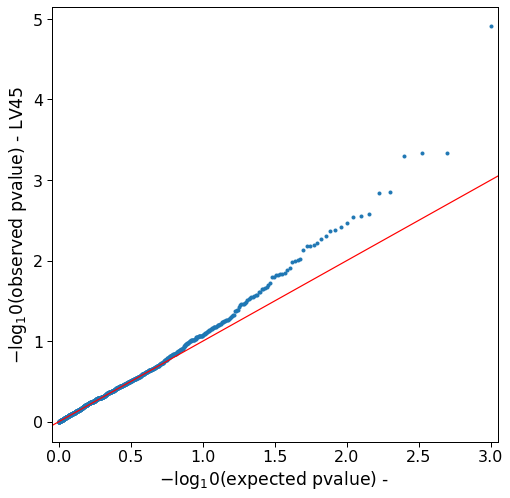

In [35]:
qqplot_unif(results)

## LV234

In [36]:
lv_code = "LV234"

In [37]:
results = dfs[dfs["lv"] == lv_code]

In [38]:
results.shape

(1000, 7)

In [39]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
1,LV234,0.020392,0.012161,1.676830,0.093624,0.046812,random.pheno988
10,LV234,0.000370,0.012145,0.030458,0.975703,0.487851,random.pheno589
19,LV234,-0.012031,0.012139,-0.991125,0.321662,0.839169,random.pheno385
28,LV234,0.009316,0.012141,0.767376,0.442886,0.221443,random.pheno5
37,LV234,0.002514,0.012168,0.206617,0.836315,0.418158,random.pheno74


In [40]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [41]:
show_prop(results, 0.01)

0.017

In [42]:
show_prop(results, 0.05)

0.061

In [43]:
show_prop(results, 0.10)

0.111

In [44]:
show_prop(results, 0.15)

0.148

In [45]:
show_prop(results, 0.20)

0.181

### QQplot

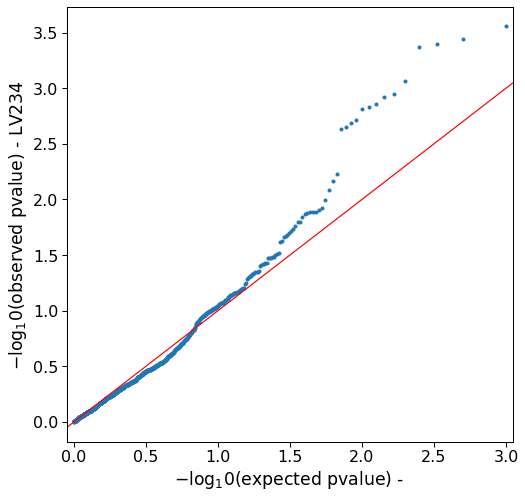

In [46]:
qqplot_unif(results)

## LV847

In [47]:
lv_code = "LV847"

In [48]:
results = dfs[dfs["lv"] == lv_code]

In [49]:
results.shape

(1000, 7)

In [50]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
2,LV847,0.010915,0.012892,0.846624,0.397236,0.198618,random.pheno988
11,LV847,0.003404,0.012911,0.263655,0.792054,0.396027,random.pheno589
20,LV847,-0.014489,0.012894,-1.123672,0.261194,0.869403,random.pheno385
29,LV847,0.007964,0.012880,0.618333,0.536378,0.268189,random.pheno5
38,LV847,0.008001,0.012933,0.618637,0.536178,0.268089,random.pheno74


In [51]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [52]:
show_prop(results, 0.01)

0.024

In [53]:
show_prop(results, 0.05)

0.062

In [54]:
show_prop(results, 0.10)

0.103

In [55]:
show_prop(results, 0.15)

0.144

In [56]:
show_prop(results, 0.20)

0.194

### QQplot

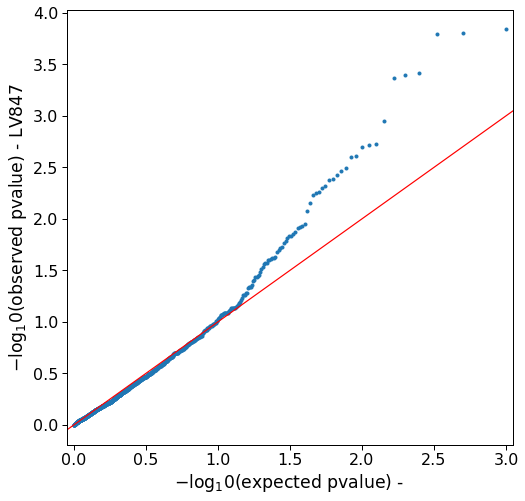

In [57]:
qqplot_unif(results)

## LV110

In [58]:
lv_code = "LV110"

In [59]:
results = dfs[dfs["lv"] == lv_code]

In [60]:
results.shape

(1000, 7)

In [61]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
3,LV110,-0.019745,0.013571,-1.454921,0.145740,0.927130,random.pheno988
12,LV110,-0.007470,0.013576,-0.550262,0.582159,0.708920,random.pheno589
21,LV110,-0.022631,0.013567,-1.668066,0.095351,0.952324,random.pheno385
30,LV110,-0.010316,0.013528,-0.762551,0.445759,0.777120,random.pheno5
39,LV110,-0.000894,0.013568,-0.065860,0.947491,0.526254,random.pheno74


In [62]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [63]:
show_prop(results, 0.01)

0.01

In [64]:
show_prop(results, 0.05)

0.04

In [65]:
show_prop(results, 0.10)

0.073

In [66]:
show_prop(results, 0.15)

0.12

In [67]:
show_prop(results, 0.20)

0.157

### QQplot

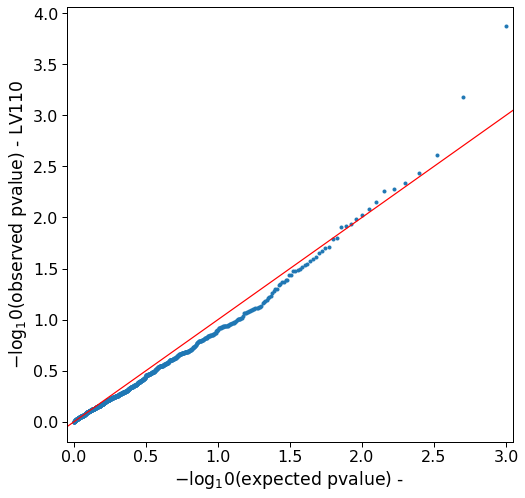

In [68]:
qqplot_unif(results)

## LV769

In [69]:
lv_code = "LV769"

In [70]:
results = dfs[dfs["lv"] == lv_code]

In [71]:
results.shape

(1000, 7)

In [72]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
4,LV769,0.014935,0.011839,1.261515,0.207169,0.103584,random.pheno988
13,LV769,0.002277,0.011800,0.192961,0.846995,0.423498,random.pheno589
22,LV769,0.002818,0.011819,0.238393,0.811584,0.405792,random.pheno385
31,LV769,-0.014463,0.011815,-1.224067,0.220972,0.889514,random.pheno5
40,LV769,-0.019554,0.011839,-1.651710,0.098642,0.950679,random.pheno74


In [73]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [74]:
show_prop(results, 0.01)

0.053

In [75]:
show_prop(results, 0.05)

0.144

In [76]:
show_prop(results, 0.10)

0.229

In [77]:
show_prop(results, 0.15)

0.299

In [78]:
show_prop(results, 0.20)

0.354

### QQplot

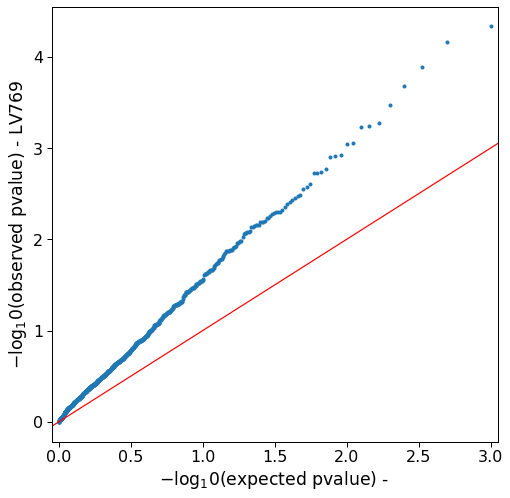

In [79]:
qqplot_unif(results)

## LV800

In [80]:
lv_code = "LV800"

In [81]:
results = dfs[dfs["lv"] == lv_code]

In [82]:
results.shape

(1000, 7)

In [83]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
5,LV800,0.005748,0.014044,0.409244,0.682374,0.341187,random.pheno988
14,LV800,-0.006631,0.014041,-0.472236,0.636775,0.681613,random.pheno589
23,LV800,-0.002274,0.014063,-0.161693,0.871552,0.564224,random.pheno385
32,LV800,-0.022199,0.014073,-1.577389,0.114755,0.942622,random.pheno5
41,LV800,-0.011534,0.014013,-0.823075,0.410496,0.794752,random.pheno74


In [84]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [85]:
show_prop(results, 0.01)

0.009

In [86]:
show_prop(results, 0.05)

0.053

In [87]:
show_prop(results, 0.10)

0.092

In [88]:
show_prop(results, 0.15)

0.142

In [89]:
show_prop(results, 0.20)

0.193

### QQplot

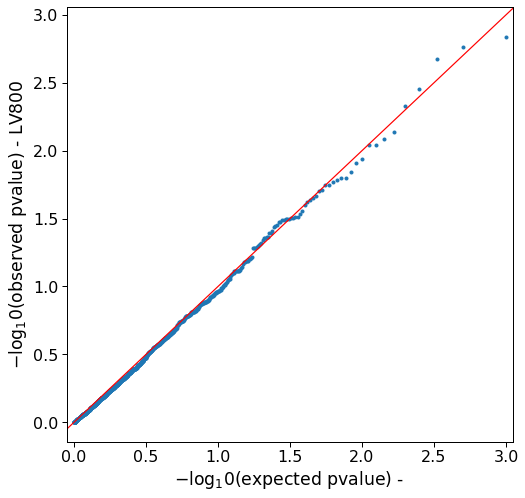

In [90]:
qqplot_unif(results)

# LVs with expected mean type I error

In [91]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10


In [92]:
lv_results_expected = {}

## LV412

In [93]:
lv_code = "LV412"

In [94]:
results = dfs[dfs["lv"] == lv_code]

In [95]:
results.shape

(1000, 7)

In [96]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
6,LV412,0.001522,0.010519,0.144715,0.884940,0.442470,random.pheno988
15,LV412,-0.003178,0.010472,-0.303509,0.761512,0.619244,random.pheno589
24,LV412,0.003330,0.010467,0.318118,0.750406,0.375203,random.pheno385
33,LV412,-0.004165,0.010528,-0.395632,0.692390,0.653805,random.pheno5
42,LV412,0.016735,0.010474,1.597754,0.110147,0.055073,random.pheno74


In [97]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [98]:
show_prop(results, 0.01)

0.012

In [99]:
show_prop(results, 0.05)

0.053

In [100]:
show_prop(results, 0.10)

0.1

In [101]:
show_prop(results, 0.15)

0.152

In [102]:
show_prop(results, 0.20)

0.193

### QQplot

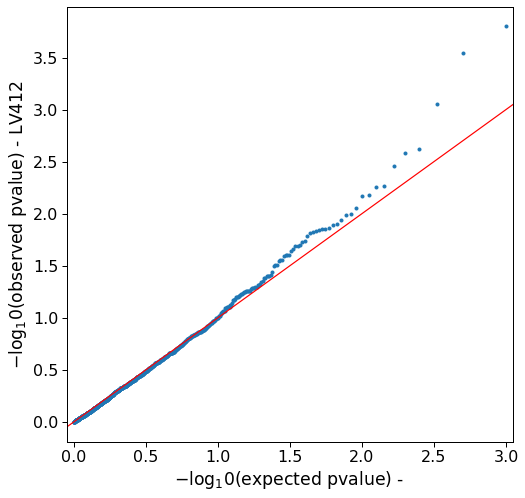

In [103]:
qqplot_unif(results)

## LV57

In [104]:
lv_code = "LV57"

In [105]:
results = dfs[dfs["lv"] == lv_code]

In [106]:
results.shape

(1000, 7)

In [107]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
7,LV57,-0.018493,0.012364,-1.495761,0.134765,0.932618,random.pheno988
16,LV57,0.016852,0.012366,1.362726,0.173016,0.086508,random.pheno589
25,LV57,0.018913,0.012372,1.528706,0.126387,0.063193,random.pheno385
34,LV57,0.000977,0.012357,0.079062,0.936986,0.468493,random.pheno5
43,LV57,0.013776,0.012332,1.117051,0.264014,0.132007,random.pheno74


In [108]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [109]:
show_prop(results, 0.01)

0.009

In [110]:
show_prop(results, 0.05)

0.059

In [111]:
show_prop(results, 0.10)

0.108

In [112]:
show_prop(results, 0.15)

0.15

In [113]:
show_prop(results, 0.20)

0.179

### QQplot

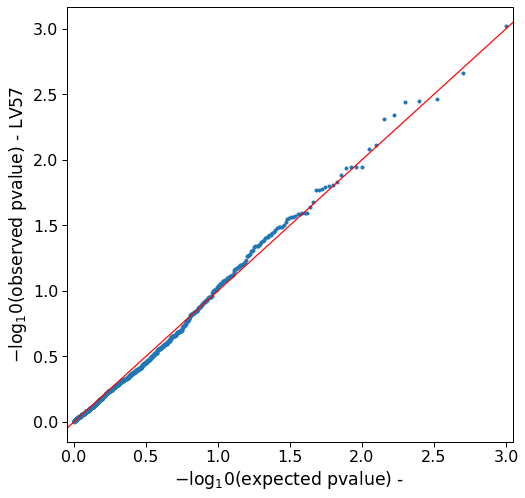

In [114]:
qqplot_unif(results)

## LV647

In [115]:
lv_code = "LV647"

In [116]:
results = dfs[dfs["lv"] == lv_code]

In [117]:
results.shape

(1000, 7)

In [118]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
8,LV647,-0.007101,0.011489,-0.618038,0.536572,0.731714,random.pheno988
17,LV647,0.013695,0.011488,1.192132,0.233253,0.116627,random.pheno589
26,LV647,0.011339,0.011488,0.987002,0.323679,0.161839,random.pheno385
35,LV647,0.002102,0.011489,0.182923,0.854864,0.427432,random.pheno5
44,LV647,0.013880,0.011460,1.211106,0.225899,0.112950,random.pheno74


In [119]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [120]:
show_prop(results, 0.01)

0.025

In [121]:
show_prop(results, 0.05)

0.071

In [122]:
show_prop(results, 0.10)

0.12

In [123]:
show_prop(results, 0.15)

0.165

In [124]:
show_prop(results, 0.20)

0.212

### QQplot

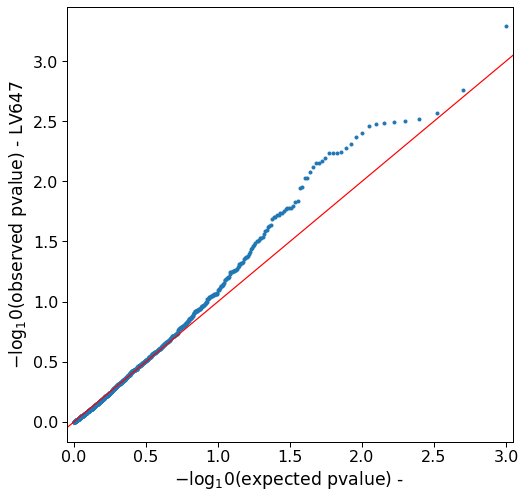

In [125]:
qqplot_unif(results)